/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:15: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


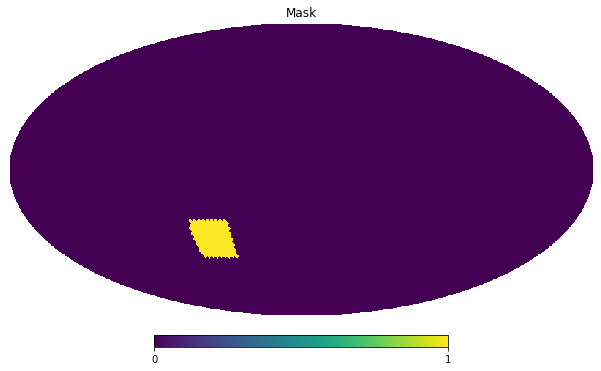

In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import h5py
import numpy as np

# Import the NaMaster python wrapper
import pymaster as nmt

# HEALPix resolution parameter used here
nside = 1024

# Read mask and apodize it on a scale of ~1deg
mask = h5py.File('/global/cscratch1/sd/chihway/data/cosmodc2/outputs/diagnostic_maps.hdf5','r')
# print(mask['maps'].keys())
depth = mask['maps/mask/value'].value
pix = mask['maps/mask/pixel'].value
# print(mask.read_map_info('mask'))
mask_map = np.zeros(hp.nside2npix(nside))
mask_map[pix] = depth
# mask_map2 = nmt.mask_apodization(mask_map, 1., apotype="Smooth")
hp.mollview(mask_map, title='Mask', nest=False)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app


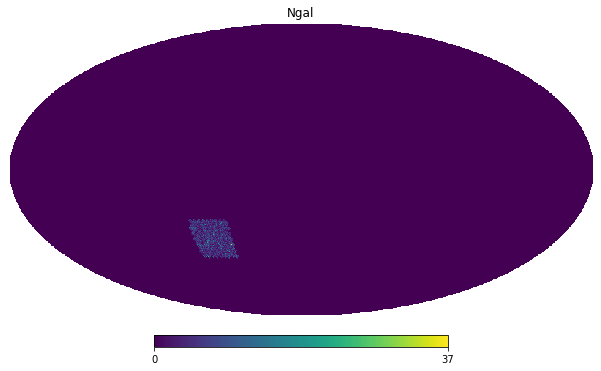

In [2]:
ngal = mask['maps/ngal_0/value'].value
pix = mask['maps/ngal_0/pixel'].value
ngal_map = np.zeros(hp.nside2npix(nside))
ngal_map[pix] = ngal
hp.mollview(ngal_map, title='Ngal', nest=False)

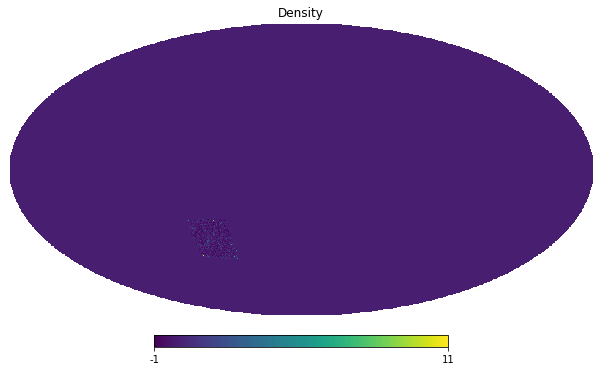

In [3]:
density_map = ngal_map.copy()
density_map[mask_map==1] = (ngal_map[mask_map==1]-np.mean(ngal_map[mask_map==1]))/np.mean(ngal_map[mask_map==1])
hp.mollview(density_map, title='Density', nest=False)

In [4]:
# open lens file, make two versions of the lens density maps

tomo = h5py.File('/global/cscratch1/sd/chihway/data/cosmodc2/outputs/tomography_catalog.hdf5','r')
photo = h5py.File('/global/projecta/projectdirs/lsst/groups/WL/users/zuntz/data/cosmoDC2-1.1.4_oneyear_unit_response/photometry_catalog.hdf5','r')

In [5]:
lens_mask = (tomo['tomography/lens_bin'].value ==0)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':


In [6]:
ra = photo['photometry/ra'].value[lens_mask]
dec = photo['photometry/dec'].value[lens_mask]

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/ipykernel/__main__.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  from ipykernel import kernelapp as app


In [7]:
ids = np.arange(len(ra))
np.random.shuffle(ids)
print(len(ids))

722665


In [8]:
ra1 = ra[ids[:int(722665/2)]]
dec1 = dec[ids[:int(722665/2)]]
ra2 = ra[ids[int(722665/2):]]
dec2 = dec[ids[int(722665/2):]]

In [9]:
theta1 = (90.0-dec1)/180*np.pi
phi1 = ra1/180*np.pi
theta2 = (90.0-dec2)/180*np.pi
phi2 = ra2/180*np.pi

In [10]:
pix1 = hp.ang2pix(nside, theta1, phi1)
pix2 = hp.ang2pix(nside, theta2, phi2)

In [11]:
ngal1 = np.zeros(hp.nside2npix(nside))
ngal2 = np.zeros(hp.nside2npix(nside))

for i in range(len(pix1)):
    ngal1[pix1[i]] += 1
for i in range(len(pix2)):
    ngal2[pix2[i]] += 1

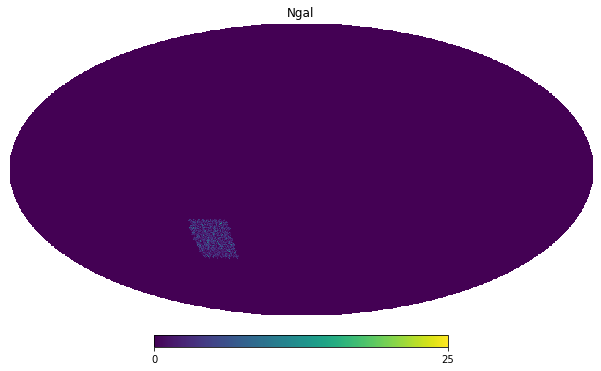

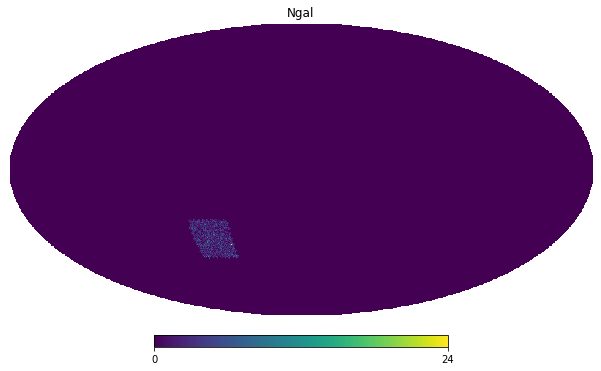

In [12]:
hp.mollview(ngal1, title='Ngal', nest=False)
hp.mollview(ngal2, title='Ngal', nest=False)

In [13]:
density_map1 = ngal1.copy()
density_map1[mask_map==1] = (ngal1[mask_map==1]-np.mean(ngal1[mask_map==1]))/np.mean(ngal1[mask_map==1])
density_map2 = ngal2.copy()
density_map2[mask_map==1] = (ngal2[mask_map==1]-np.mean(ngal2[mask_map==1]))/np.mean(ngal2[mask_map==1])
diff_map = density_map1-density_map2

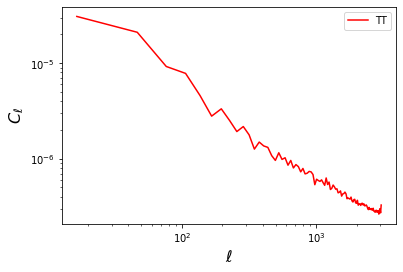

In [14]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_0 = nmt.NmtField(mask_map, [density_map])

# Initialize binning scheme with 4 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 30)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)

# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00[0], 'r-', label='TT')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

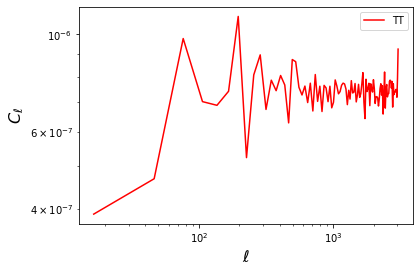

In [15]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_0_noise = nmt.NmtField(mask_map, [diff_map])

# Initialize binning scheme with 4 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 30)

# Compute MASTER estimator
# spin-0 x spin-0
cl_00_noise = nmt.compute_full_master(f_0_noise, f_0_noise, b)

# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00_noise[0], 'r-', label='TT')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

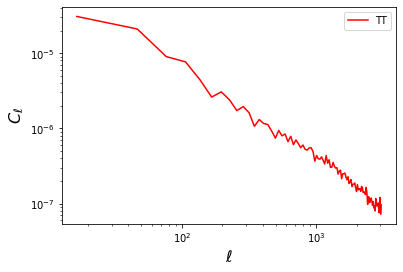

In [16]:
plt.plot(ell_arr, cl_00[0]-cl_00_noise[0]/4, 'r-', label='TT')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()